# Lab 5: Word Counting and Embedding Clustering

**Author:** Marcus Klang (Marcus.Klang@cs.lth.se)

## Goals:
 * Learn how to read, transform and process text data with Pyspark
 * Preprocess and create a suitable dataset for clustering
 * Use KMeans from sklearn and cluster 10 000 words to 200 clusters
 * Write a function which displays words nearby
 
## Outline of the lab

 * You will first solve a few exercises on Spark to learn how to write basic commands.
 * You will then apply Spark to extract the 10,000 most frequent words in the English Wikipedia.
 * As this corpus is very large, you will use 1% of it in the lab, the full Wikipedia is available.
 * You will finally cluster these words into 100 groups using their GloVe100 representation.
 * As clustering program, you will use KMeans from sklearn.

In [1]:
# When a cell contains TODO, you shall replace TODO with relevant code.

**Task 0**: Add 1 to 1

In [2]:
1+1 #TODO

2

Answer

In [3]:
1+1

2

## Spark and Pyspark documentation

General documention is available online when you need to look up the parameters of a function:
 
 * [Pyspark RDD](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html)
 * [Pyspark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html)
 * [Spark](https://spark.apache.org/docs/2.4.0/)

# Part 0: Dependencies

Import these packages

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [5]:
GLOVE_6B_100D_PATH='/h/d6/z/tpi14lan/Desktop/Lab4/Glove'
ENWIKI_1P_PATH="/usr/local/cs/EDAN95/datasets/wikipedia/enwiki_1p"

Copy glove.6B.100d.txt from [Assignment 4](http://cs.lth.se/edan95-applied-machine-learning/lab-programming-assignments/assignment-4/) and set path above

**If you are on your own computer:**

1. Download the 1% Enwiki Paragraph dataset from http://fileadmin.cs.lth.se/cs/Education/EDAN95/Data/enwiki_1p.zip 
2. Extract relative to notebook
3. Make sure the relative directory contains "part-*" files.

## Spark

If you are using the computers in the lab rooms then everything is ready.

**On your own computer:**

These instructions are given in the hope that they are useful and help get you started, support will be minimal to none:

 1. [Download Spark (Mirror choser - get real link from this page)](https://www.apache.org/dyn/closer.lua/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz), link from [https://spark.apache.org/]
 2. Unpack this directory, copy the path to this directory
 3. Make sure you have the [Java 8 **JDK**](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) installed and it is the default java. **Spark does not support Java 9+**, if your default java is 9+, then you have to set and export the environment variable JAVA_HOME with the proper location of your java 8 installation before starting your notebook/lab server, which implies that you need to restart the server running this notebook.
 4. Modify SPARK_HOME in the cell below with the copied path and run it.

In [6]:
# This path should point to a location which contains a bin and python directory
SPARK_HOME='/usr/local/spark'
os.environ["SPARK_HOME"] = SPARK_HOME
sys.path.append(os.path.join(SPARK_HOME, "python"))
sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "py4j-0.10.7-src.zip"))

# Part 1: Pyspark RDD

In [7]:
from pyspark import SparkContext   # The main context
from pyspark.sql import SQLContext # The SQL CONTEXT

This utility function will resolve a correct path for Spark

In [8]:
def pyspark_path(filepath):
    return "file:%s" % os.path.abspath(filepath)

We will now create a ```SparkContext``` for testing purposes i.e. run it locally and use all available cores.

```local[*]```, the ```*``` defines the number of cores to use (* = all, 1 = one core, 4 = four cores, etc.).

This will create the Py4j bridge, and start a background JVM which runs the Spark Engine.

In [9]:
sc = SparkContext(master="local[*]", appName="Lab 5")

The ```sc``` variable will provide a link to the driver webpage where status information can be found, along with all settings and more.

In [10]:
sc

<SparkContext master=local[*] appName=Lab 5>

## Part 1.1 Tiny steps with Pyspark

The objective of this section is to get you familiar with different transformations and actions.

All tasks will contain links to the function to use when a new concepts are introduced, when no links exists you are expected to use suitable functions.

Create some dummy data, 100 000 elements from 0 to 99 999, use 8 partitions

In [11]:
dataset = sc.parallelize(list(range(100000)), 8) # Define the dataset of dummy data with paralellize of list.

**Task 1:** Print the 5 first elements, use the [take](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.take) function

In [12]:
dataset.take(10) # Use take function on dataset.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

**Task 2:** Use [reduce](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.reduce) to sum all values

In [13]:
from operator import add

dataset.reduce(add) # reduce(add) -> sums

4999950000

**Task 3:** Sum the values using the [sum](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.sum) function

In [14]:
dataset.sum() # sum operator

4999950000

**Task 4:** Compute the mean using the [mean](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.mean) function

In [15]:
dataset.mean()

49999.5

**Task 5:** Add 15 to all elements using [map](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.map), take the first 5 elements

In [16]:
dataset.map(lambda x: x + 15).collect()[0 : 5]

[15, 16, 17, 18, 19]

**Task 6:** Repeat task 5 but use a function instead of a lambda

In [17]:
def myFunc(x):
    return x + 15

dataset.map(myFunc).collect()[0 : 5]

[15, 16, 17, 18, 19]

**Task 7:** Filter out odd numbers (divisble by 2 is ```x % 2 == 0```) and compute the mean

In [18]:
def isEven(x):
    return x % 2 == 0

dataset.filter(isEven).mean()

49999.0

**Task 8:** Find all odd numbers between 10 000 and 50 000 (inclusive), add 134, find all divisible by 17, [collect](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.collect) and [count](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.count) them.

In [19]:
def inRange(x):
    return 10000 <= x <= 50000

dataset.filter(inRange).map(lambda x: x + 134).filter(lambda x: x % 17 == 0).count()

2353

## Part 1.2 The execution model

Pyspark uses multiple processes for parellization as CPython lacks native threading.

Although possible, shared memory is not used, which means all processes are unique and data which resides in the driver is copied when needed, and state is not transfered

In [20]:
import random

In [21]:
for i in range(3):
    random.seed(1)
    print(dataset.map(lambda x: x+random.randint(0,100)).sum())

5004962045
5004930951
5004970425


Exepected output above is 3 different values, as the random state from the driver is not copied to the executor.

Now we will attempt to make it predictable, by seeding in each process and using a function instead of a lambda.

In addition, the code below will not return all values, instead it will compute a single sum within each partition.

In [22]:
def predictable_map_partition(indx, partition):
    # Whatever code you write here, will run in the executor
    random.seed(indx)
    return [sum(x+random.randint(0,100) for x in partition)]

for i in range(3):
    print(dataset.mapPartitionsWithIndex(predictable_map_partition).sum())

5004933586
5004933586
5004933586


The output of above is predictable as each partition will be seeded in a predictable manner.

## Part 1.3 Sharing read-only data between executors

It is not uncommon to need some data to be shared between executors.

Common use cases are:
 * Sets/Dictionaries for fast in-memory lookup
 * User-defined objects which contains parameters for the algorithm that should be parallelized
 * General in-memory objects which are used frequently but never modified. These objects might have expensive intialization (such as loading a model, etc.)

Data is shared using a mechanism called *[Broadcasts](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.Broadcast)*, these are serialized objects which are distributed efficiently and shared across muliple calls within a pipeline.

```pickle```is used to serialize objects to transmit over network or locally to executor processes.

In [23]:
lookup = sc.broadcast({"a": "x", "b":"y", "c": "z"})

In [24]:
sc.parallelize(["abc", "def"],1).map(lambda x: "".join([lookup.value.get(ch,ch) for ch in x])).collect()

['xyz', 'def']

In [25]:
setlookup = sc.broadcast(set(["def"]))
sc.parallelize(["abc", "def"],1).filter(lambda x: x in setlookup.value).collect()

['def']

## Part 1.4: Real data

We will be using a 1% sample of all paragraphs in English Wikipedia from October 2018.

The data has been segmented in advance, the following specifics apply:
 
 * Tokens/Words are seperated by space ' '
 * Sentences are seperated by tab characters, '\t'
 * Paragraphs are seperated by newlines, which means that each entry is a full paragraph.

In [26]:
paragraphs = sc.textFile(pyspark_path(ENWIKI_1P_PATH))

**Task 9**: Display the first 5 paragraphs

In [27]:
paragraphs.collect()[0 : 5]

['Dundee United played a total of 35 matches during the 1936–37 season .',
 'On January 17 , the Whalers acquired Wayne Babych , the older brother of Whalers defenseman Dave Babych , from the Quebec Nordiques , in exchange for Greg Malone .\tBabych , who was acquired by Quebec from the Pittsburgh Penguins earlier in the season , had six goals and 11 points in 15 games with the Nordiques .\tHis best season came in 1980-81 , while as a member of the St. Louis Blues , Babych scored 54 goals and 96 points in 78 games .\tDuring that season , he led the NHL with 40 even strength goals .',
 'Amanda Swisten ( born December 20 , 1978 ) is a former American model and actress of Scandinavian / Slavic descent , who has appeared in various films and TV shows .',
 'It was also covered by The Kooks along with the Buena Vista Social Club in 2007 on the album Rhythms del Mundo Classics .',
 'No tests of nuclear devices took place in Area 27 .']

**Task 10.** Count the number of paragraphs

In [28]:
paragraphs.count()

355520

**Task 11:** [Sample](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.sample) 1% of these paragraphs, and display the first 5

The use-case of sampling is to speed up testing, getting a downsampled version of the dataset retains the statistical properties.

Please use sampling if execution times are too long. Another tip is to cache the 1% sample in memory for even better performance using [cache()](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.cache), more fingrained caching can be controlled using [persist()](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.persist) and [StorageLevels](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.StorageLevel)

In [29]:
sample = paragraphs.sample(False, 0.01, 1)

sample.collect()[0 : 5]

['According to the Australian Bureau of Statistics ( ABS ) seasonally adjusted estimates , the unemployment rate decreased 0.1 % to 5.5 % in September 2017 while the labor force participation rate remained steady at 65.2 % .\tThe trend participation rate for 15 - to 24 - year - olds increased by 0.3 percentage points to 67.7 per cent while unemployment rate for this group declined by less than 0.1 % to 12.7 % , decreasing by 0.3 % over the year .\tAccording to the Australian Bureau of statistics , in August 2017 , the quarterly underemployment rate decreased by 0.2 % to 8.6 % while the quarterly underutilisation rate ( the unemployed plus the under - employed ) decreased by 0.2 % to 14.1 per cent .',
 'Fearing that the rebellion would spread into her domain , Catherine the Great , the Empress of Russia , dispatched a regiment of Don Cossacks to help Poland suppress the rebellion .\tThe commander of the Russian unit , a certain Guriev , made the Cossacks believe he was siding with them 

## Part 2: Preprocessing

The objective of this part is to count words by doing the following parts:
    
 * Convert paragraphs into tokens
 * Normalize tokens into lowercase
 * Count per token
 * Sort and retrieve the top 10000 words in the provided dataset

**Task 12**: Split paragraphs into tokens using [flatMap](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.flatMap), display first 10 tokens

In [30]:
tokens = sample.flatMap(lambda x: x.split())
tokens.collect()[0 : 10]

['According',
 'to',
 'the',
 'Australian',
 'Bureau',
 'of',
 'Statistics',
 '(',
 'ABS',
 ')']

**Task 13:** Lower-case the tokens, display first 10 tokens

In [31]:
tokens = tokens.map(lambda x: x.lower())

tokens.collect()[0 : 10]

['according',
 'to',
 'the',
 'australian',
 'bureau',
 'of',
 'statistics',
 '(',
 'abs',
 ')']

*Remember* you can use a 1% sample during testing

**Task 14:** Count tokens using *map* and [reduceByKey](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.reduceByKey), filter out ```sweden, lund, skåne, learning, spark```, and display counts for these.

In [32]:
listaTokens = tokens.collect()

inputData = list(zip(listaTokens, [1] * len(listaTokens)))
inputData[0 : 10]

rdd = sc.parallelize(inputData)

tokenCount = rdd.reduceByKey(add)


words = ["sweden", "lund", "skåne", "learning", "spark"]

occurences = tokenCount.filter(lambda x: x[0] in words).collect()

print(occurences)

[('learning', 7), ('spark', 3), ('sweden', 12), ('lund', 1)]


**Task 15:** Count the total number of tokens in the corpus

In [33]:
print(len(tokenCount.collect()))

28327


**Task 16:** Take the top 10 000 most frequent tokens using [takeOrdered](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.takeOrdered).

Save the result in a variable called ```top10000```

In [34]:
top10000 = tokenCount.takeOrdered(10000, lambda x: -x[1])

In [35]:
len(top10000)

10000

## Part 3: Process Glove, and extract the embeddings for the top 10000 words

The objective of this part is:

 * Parse the Glove 6B embedding
 * Filter out only the embeddings matching words that exists in the top 10 000 words.
 * Produce the X which we will cluster

**Task 17:** Load Glove 6B 100d embeddings into a variable ```glove6B```

In [36]:
glove6B = sc.textFile(pyspark_path(GLOVE_6B_100D_PATH))

type(glove6B)

pyspark.rdd.RDD

**Task 18:** Count the number of embeddings and print the first 5

In [37]:
glove6B.count()

400000

In [38]:
glove6B.take(5)

['the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062',
 ', -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.

**Task 18:** Parse the embedding by using a function which splits the input into tuples of (word, embedding), display the first 5

In [39]:
def splitting(input):
    splitted = input.split()
    numbers = splitted[1 : ]
    first = splitted[0]
    second = [float(x) for x in numbers]
    return (first, second)

In [40]:
splitted = glove6B.map(splitting)
#splitted.take(5)
#splitted.count()
#type(splitted)

**Task 19:** Filter out the top 10000 embeddings using the provided broadcast ```top10000_set``` which uses the previous ```top10000```variable and use [collectAsMap](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.collectAsMap) to get a dictionary of the words

In [41]:
top10000_set = sc.broadcast(set([word for word, cnt in top10000]))
type(top10000_set)
type(splitted)

pyspark.rdd.PipelinedRDD

In [42]:
filtered = splitted.filter(lambda x: x[0] in top10000_set.value)
top10000_emb = filtered.collectAsMap()
#print(top10000_emb.values()[:2])

Not all 10 000 words exists in Glove, **9 962** is the expected count

In [102]:
len(top10000_emb)

9762

In [103]:
type(top10000_emb)

dict

**Task 20:** Produce the X that we will cluster.

1. Produce a sorted list of tokens
2. Transform list into a list of embeddings and create a numpy array from it

In [121]:
# Create sorted list of tokens
# Start by creating a list that we fill with tokens from top10000_emb -> sort it

# Creating the list
keys = top10000_emb.keys()
keylist = list(keys)
keylist.sort()
print(keylist[:1])

['!']


In [130]:
X= [top10000_emb[token] for token in keylist]
X = np.asarray(X)

## Part 4: Cluster X using KMeans and visualize the results

 * Cluster these embeddings into 100 clusters using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) from scikit-learn
 * Visualize the results

In [127]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [128]:
kmeans = KMeans(n_clusters=100, n_jobs=-1, random_state=2018)

In [129]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=2018, tol=0.0001, verbose=0)

The code below computes the score which follows this equation:

\begin{equation*}
-\sum_{i=1}^n (\sum_{k=1}^{100} (x_{i,k} - {xc}_{i,k})^2)
\end{equation*}

Where $x$ is the embedding, $xc$ is the assigned cluster center.

*In words:* It is the negative sum of squared differences per dimension (100d).

In [131]:
kmeans.score(X)

-165433.21244280902

**Task 21:** Predict clusters, the output will be indicies. You will find how in the documentation of [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

In [135]:
X_clusters = kmeans.fit_predict(X)

In [136]:
X_clusters[0:10]

array([24,  3, 90, 40,  5,  3, 24, 24, 24,  3], dtype=int32)

**Task 22:** Create mapping from word to cluster

In [168]:
# Vill mappa X -> X_cluster ?

wordtoclust = dict(zip(keylist,X_clusters))
wordtoclust

{'!': 24,
 '"': 3,
 '$': 90,
 '%': 40,
 '&': 5,
 "'": 3,
 "'d": 24,
 "'m": 24,
 "'re": 24,
 "'s": 3,
 '(': 71,
 ')': 3,
 '*': 96,
 '+': 96,
 ',': 3,
 '-': 3,
 '-0': 96,
 '-1': 96,
 '-10': 96,
 '-105': 8,
 '-12': 96,
 '-15': 96,
 '-16': 96,
 '-17': 96,
 '-18': 96,
 '-1990': 8,
 '-2': 96,
 '-20': 96,
 '-2000': 8,
 '-21': 8,
 '-22': 96,
 '-25': 96,
 '-28': 8,
 '-3': 96,
 '-31': 8,
 '-33': 8,
 '-4': 96,
 '-42': 8,
 '-47': 8,
 '-49': 8,
 '-6': 96,
 '-7': 96,
 '-73': 8,
 '-75': 8,
 '-79': 8,
 '-8': 96,
 '-84': 8,
 '-85': 8,
 '-9': 96,
 '.': 3,
 '/': 96,
 '0': 96,
 '0.2': 40,
 '0.3': 40,
 '0.48': 40,
 '0.5': 40,
 '0.52': 40,
 '0.7': 40,
 '0.99': 40,
 '00': 96,
 '07': 47,
 '08': 47,
 '09': 47,
 '1': 71,
 '1,000': 14,
 '1,250': 14,
 '1,500': 14,
 '1,600': 14,
 '1.1': 40,
 '1.2': 40,
 '1.4': 40,
 '1.5': 14,
 '1.6': 40,
 '10': 71,
 '10,000': 14,
 '10.1': 40,
 '100': 14,
 '1000': 14,
 '101': 72,
 '104': 72,
 '105': 72,
 '107': 72,
 '108': 72,
 '1080': 62,
 '109': 72,
 '11': 71,
 '11.2': 40,
 '110'

**Task 23:** Create mapping from cluster to all words in cluster

In [157]:
clustertowords = {i: [] for i in range(0,100)}
for (word, cluster) in wordtoclust.items():
    clustertowords[cluster].append(word)
clustertowords

{0: ['amateur',
  'arenas',
  'athletes',
  'athletic',
  'athletics',
  'badminton',
  'baseball',
  'basketball',
  'bowling',
  'boxing',
  'championship',
  'championships',
  'chess',
  'club',
  'clubs',
  'coach',
  'coached',
  'coaches',
  'coaching',
  'collegiate',
  'compete',
  'competed',
  'competing',
  'competition',
  'competitions',
  'cricket',
  'equestrian',
  'federation',
  'fifa',
  'football',
  'footballer',
  'games',
  'golf',
  'gymnastics',
  'hockey',
  'indoor',
  'inducted',
  'itf',
  'junior',
  'karate',
  'league',
  'leagues',
  'ncaa',
  'olympic',
  'olympics',
  'played',
  'player',
  'players',
  'playing',
  'professional',
  'professionally',
  'referee',
  'rivalry',
  'rugby',
  'skate',
  'snooker',
  'soccer',
  'sport',
  'sporting',
  'sports',
  'squad',
  'squash',
  'super',
  'swimming',
  'team',
  'teams',
  'tennis',
  'tier',
  'tournaments',
  'uefa',
  'usa',
  'volleyball',
  'wrestler',
  'wrestling',
  'youth'],
 1: ['age

**Task 24**: Create a list of all cluster sizes, i.e. the number of words in each cluster

In [162]:
cluster_size = {}

for i in clustertowords.keys():
    cluster_size[i] = len(clustertowords[i])
#print(cluster_size[0:3])
cluster_size
csize = [siz for i, siz in cluster_size.items()]
csize

[75,
 95,
 53,
 195,
 79,
 176,
 136,
 221,
 321,
 200,
 76,
 78,
 107,
 52,
 69,
 108,
 102,
 92,
 83,
 93,
 34,
 70,
 130,
 79,
 178,
 49,
 81,
 56,
 54,
 61,
 76,
 185,
 144,
 95,
 106,
 129,
 53,
 63,
 90,
 80,
 53,
 148,
 57,
 74,
 96,
 108,
 108,
 37,
 106,
 77,
 57,
 151,
 88,
 83,
 67,
 109,
 70,
 125,
 104,
 120,
 96,
 83,
 134,
 70,
 117,
 85,
 160,
 63,
 98,
 126,
 100,
 44,
 100,
 93,
 48,
 56,
 80,
 67,
 48,
 95,
 55,
 111,
 170,
 112,
 122,
 77,
 51,
 144,
 78,
 142,
 124,
 101,
 138,
 68,
 62,
 92,
 74,
 70,
 91,
 55]

Plot the histogram

(array([20., 31., 26., 13.,  4.,  4.,  1.,  0.,  0.,  1.]),
 array([ 34. ,  62.7,  91.4, 120.1, 148.8, 177.5, 206.2, 234.9, 263.6,
        292.3, 321. ]),
 <a list of 10 Patch objects>)

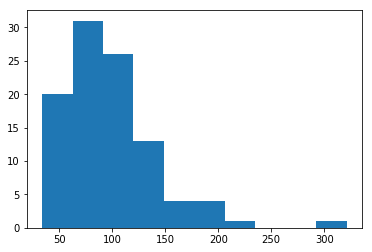

In [166]:
plt.hist(np.array(csize))

**Optionally:** Look at the words in the smallest and largest cluster, do you see any structure?

**Task 25:** Implement the get_nearby function

In [171]:
def get_nearby(word):
    clust = wordtoclust.get(word)
    listret = clustertowords.get(clust)    
    """
    Get all words from the same cluster as the input
    
    Returns: list of words having the same cluster"""
    
    return listret

In [172]:
get_nearby("sweden")

['abkhazia',
 'anatolia',
 'andorra',
 'austria',
 'austrian',
 'azerbaijani',
 'belarus',
 'belgium',
 'bulgaria',
 'bulgarian',
 'bulgarians',
 'caucasus',
 'croatia',
 'croatian',
 'czech',
 'danish',
 'denmark',
 'dutch',
 'european',
 'finland',
 'finnish',
 'france',
 'french',
 'georgian',
 'german',
 'germany',
 'greece',
 'herzegovina',
 'hungarian',
 'hungary',
 'italian',
 'italy',
 'latvia',
 'lithuania',
 'luxembourg',
 'macedonia',
 'macedonian',
 'malta',
 'moscow',
 'netherlands',
 'norway',
 'norwegian',
 'petra',
 'poland',
 'polish',
 'portugal',
 'republic',
 'romania',
 'romanian',
 'russia',
 'russian',
 'russians',
 'serbian',
 'sfr',
 'slovak',
 'slovenian',
 'sweden',
 'swedish',
 'swiss',
 'switzerland',
 'tunisia',
 'turkey',
 'ukraine',
 'ukrainian',
 'ussr',
 'yanukovych',
 'yugoslav']

In [173]:
words = ["king", "sweden", "obama", "home", "learning"]
clusters = [get_nearby(word) for word in words]
cluster_colors = ["red", "green", "blue", "purple", "teal"] # HTML colors are allowed inside here.

Flatten words and clusters

In [180]:
all_words = [word for cluster in clusters for word in cluster]
all_cluster_color = [
    cluster_color for cluster_color_array in 
    (
        [color] * len(cluster)
        for cluster, color in 
        zip(clusters, cluster_colors)
    )
    for cluster_color
    in cluster_color_array
]
#type(all_words)

**Task 26:** Use ```all_words``` and translate into a numpy array called ```X_words``` of all embeddings

In [197]:
# np.vstack
X_words = np.vstack([top10000_emb.get(w)] for w in all_words)


[**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) is a dimensionality reduction algorithm useful for projecting high dimensional data into a low dimensional space such as 2D, which we can plot and more easily understand spatially.

In [198]:
tsne = TSNE(n_components=2, random_state=2018)

In [199]:
X_pos = tsne.fit_transform(X_words)

The code below makes a large plot using Matplotlib and attaches labels to all points. It provided for reference and a fallback if the more advanced visualization fails.

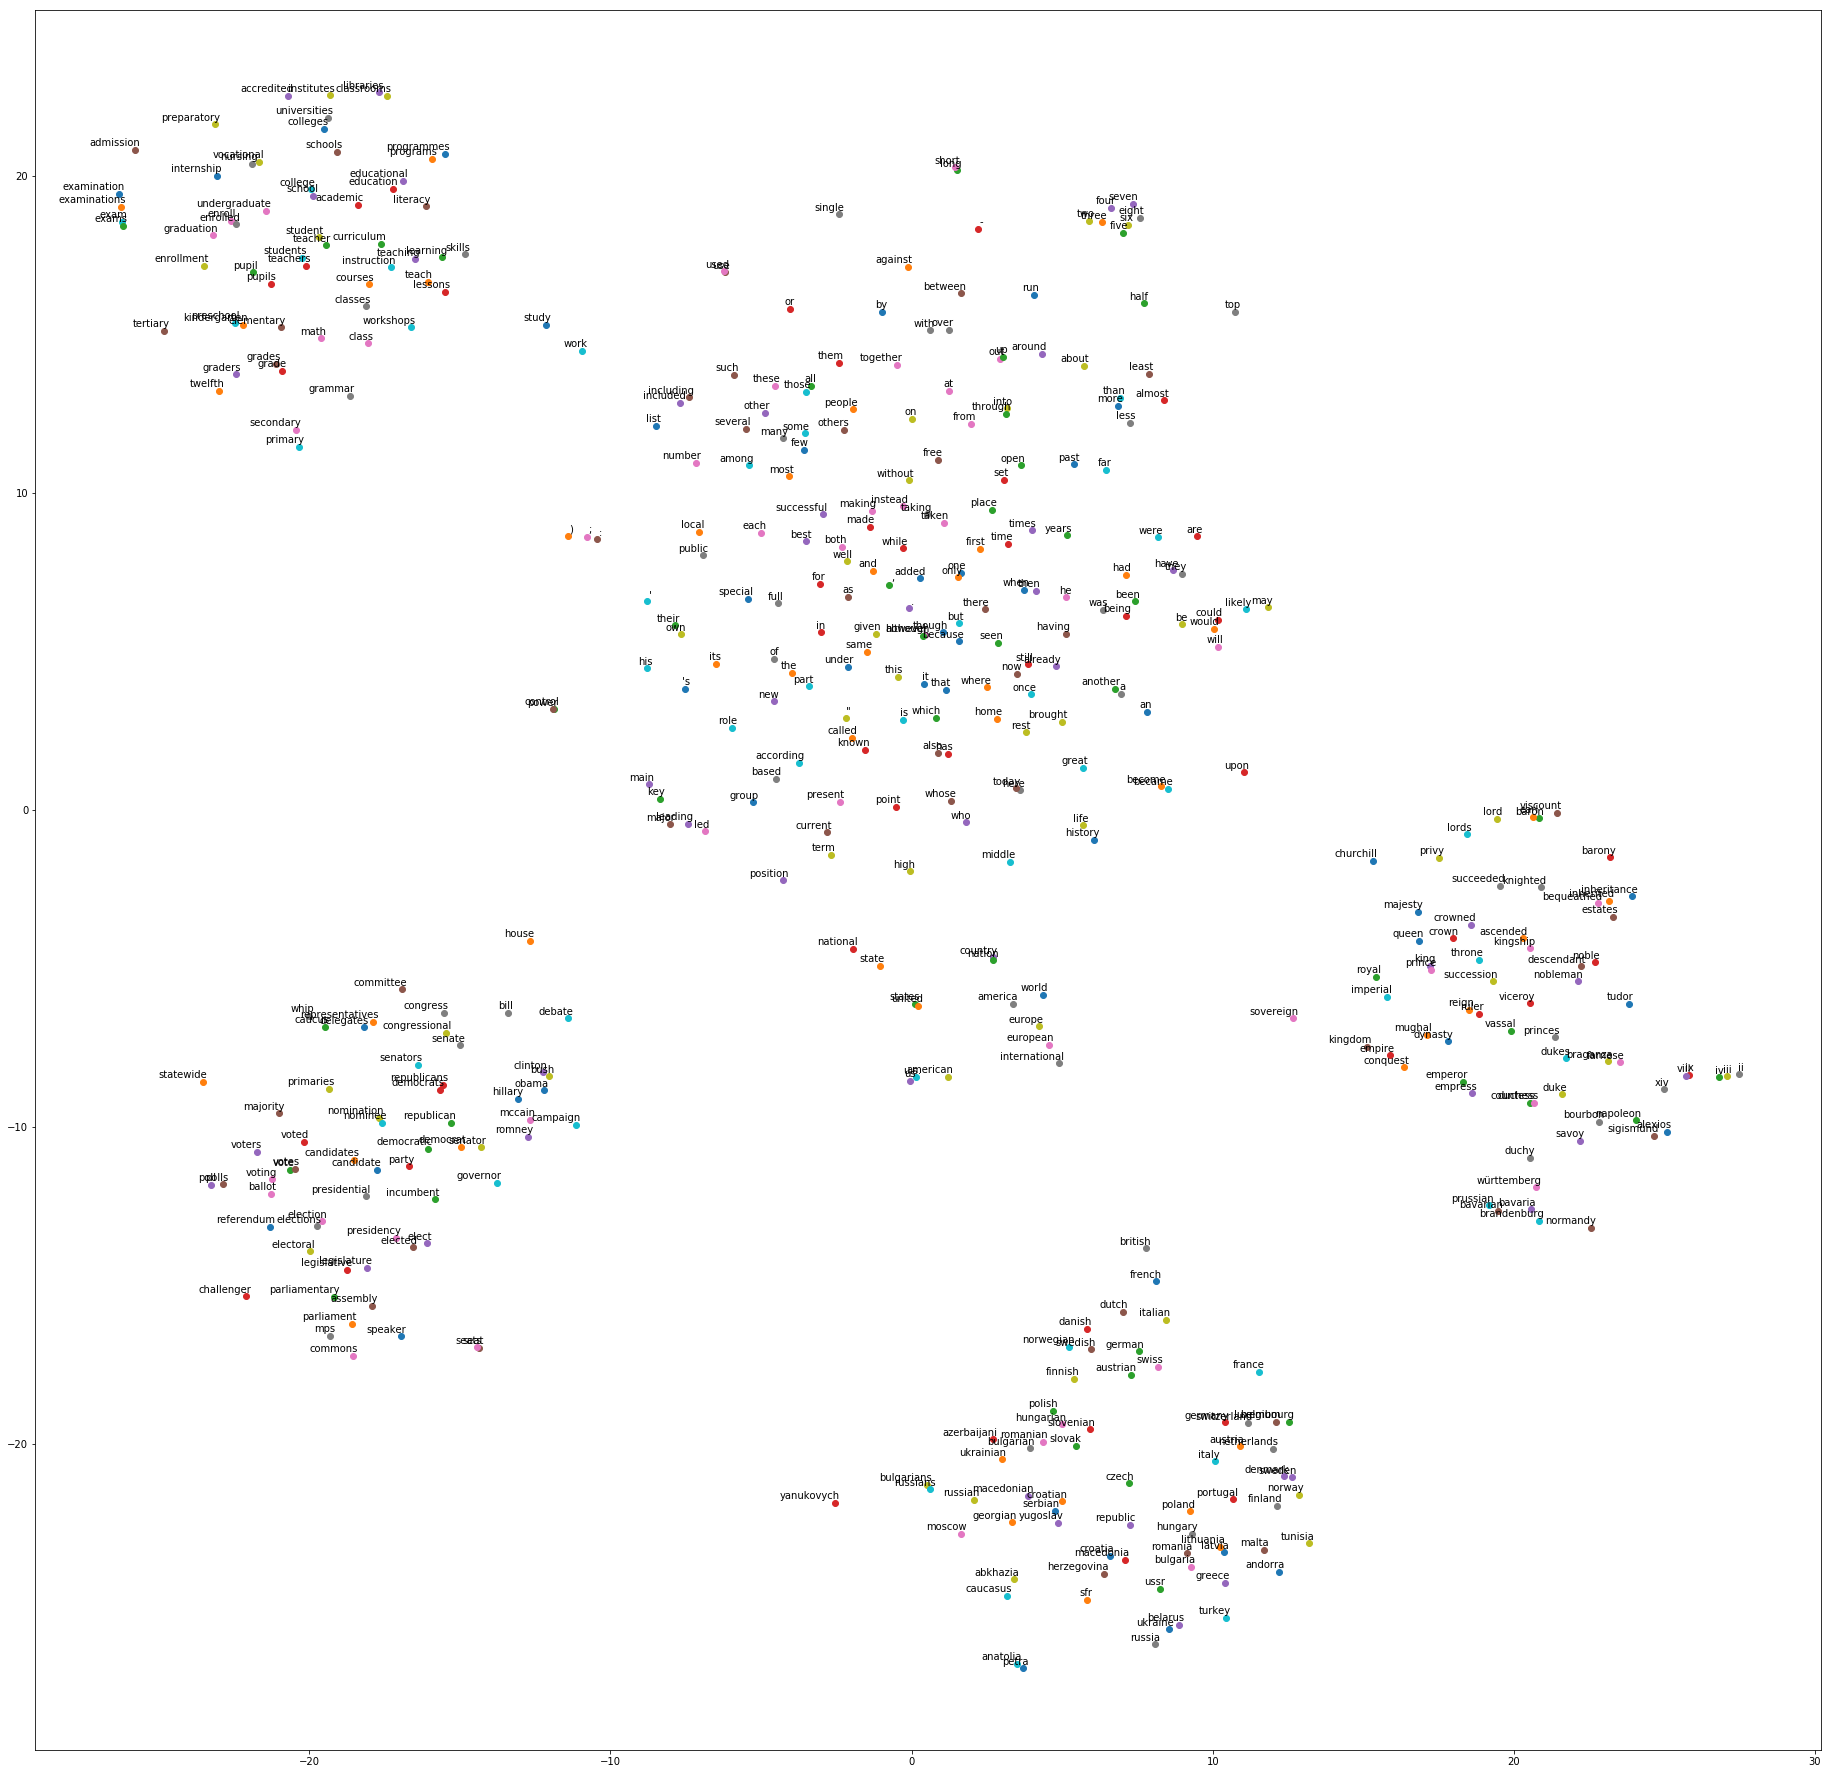

In [200]:
# Visualize using matplotlib and produce an image of the points and words
labels = all_words
x = []
y = []
for x_val,y_val in X_pos:
    x.append(x_val)
    y.append(y_val)

plt.figure(figsize=(32, 32)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

### Interactive Visualization: D3.js
The cells below will produce a HTML file that has the previously plotted image embedded as JSON.

The code below is provided for visualization purposes: to understand it is not a requirement.

The standard output is ```visualize.html```

In [201]:
import json

In [202]:
# Scale to fit box of dimensions below
WIDTH = 768.0
HEIGHT = 768.0
OUTPUT_FILE = "visualize.html"

In [203]:
# Run this cell to set the template
HTML_TEMPLATE = """
<!DOCTYPE html>
<head>
  <style>

      html {
        font-family: "Helvetica Neue", Helvetica, arial, sans-serif;
        font-size: 16px;
      }

      body {
        margin: 0;
        padding: 0;
        width: 100%;
        width: 100%;
        overflow: hidden;
      }

      svg {
        display: block;
        width: 100%;
        height: auto;
      }

      div#container {
        overflow: hidden;
      }
    </style>
    <meta charset="utf-8">
</head>
<body>
  <div class="container">
<svg width="640" height="480"></svg>
<script src="https://d3js.org/d3.v4.min.js"></script>

<!-- Here is our data -->
<script id="raw-data" language="application/json">
__OUTPUT_JSON__
</script>
<script>

// Parse data from tag inside this doucment
var inputdata = JSON.parse(document.getElementById('raw-data').innerHTML);

var svg = d3.select("svg"),
    width = +svg.attr("width"),
    height = +svg.attr("height");

// Create a dummy array with indicies
var indicies = d3.range(inputdata.length);

// Produce points with some zoom magic
var circle = svg.selectAll("circle")
  .data(indicies)
  .enter()
  .append("circle")
    .attr("r", 2.5)
    .attr("fill", function(d) {return inputdata[d]["color"]})
    .attr("transform", transform(d3.zoomIdentity));

// Produce labels attached/placed relative to points
var lbls = svg.selectAll("texts")
                .data(indicies)
                .enter()
                .append("text")
                .text(function(d) {
                  return inputdata[d]["label"];
                })
                .attr("font-size", "15px")
                .attr("fill", function(d) {return inputdata[d]["color"]})
                .attr("transform", transform(d3.zoomIdentity));

// Will recieve index, and produce transform directive for that index
function transform(t) {
  return function(d) {
    return "translate(" + t.apply(inputdata[d]["position"]) + ")";
  };
}

// Zoom transformation function
function zoom() {
  circle.attr("transform", transform(d3.event.transform));
  lbls.attr("transform", transform(d3.event.transform));
}

// Add the zoom handler, that listens to events.
svg.append("rect")
    .attr("fill", "none")
    .attr("pointer-events", "all")
    .attr("width", "100%")
    .attr("height", "100%")
    .call(d3.zoom()
        .scaleExtent([1, 16]) //The minimum and maximum scale factor 
        .on("zoom", zoom));

</script>
</div>
</body>
</html>
"""

In [204]:
# Find extents
x_extents = [min(pos[0] for pos in X_pos), max(pos[0] for pos in X_pos)]
y_extents = [min(pos[1] for pos in X_pos), max(pos[1] for pos in X_pos)]

# Compute translation
translation = [-x_extents[0], -y_extents[0]]

# Compute scaling, flip y to match convention that y is down not up.
scale = [WIDTH/(x_extents[1]-x_extents[0]), -HEIGHT/(y_extents[1]-y_extents[0])]

# Produce JSON dictionary
output = []
labels = all_words
for (x_val, y_val), label, color in zip(X_pos, labels, all_cluster_color):
    output.append({"position": ((float(x_val)+translation[0])*scale[0], (float(y_val)+translation[1])*scale[1]+HEIGHT), "label": label, "color": color})

# Write HTML file with JSON embedded
with open(OUTPUT_FILE, "w") as fout:
    fout.write(HTML_TEMPLATE.replace("__OUTPUT_JSON__", json.dumps(output)))

Open the HTML file in your favorite browser.

How to use:
 * Drag to move the image around
 * Zoom using the mousewheel, default min and max zoom values have been set.

**Note:** *Internet access is required* for the page to work. The page downloads d3.js during start-up from https://d3js.org/d3.v4.min.js